# LSTM 사용 Baseline

install modules & wandb, gdrvie 연동

In [ ]:
!pip install konlpy
!pip install wandb

In [39]:
!wandb login

wandb: Currently logged in as: yerim (use `wandb login --relogin` to force relogin)


import line

In [22]:
import pandas as pd
import numpy as np
import json
import ast
from konlpy.tag import Okt, Hannanum, Komoran, Kkma

import wandb
from wandb.keras import WandbCallback

import random
import copy
import time
import gc
import re
import torch
import os 

import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

from collections import Counter
from nltk import word_tokenize
from multiprocessing import  Pool
from functools import partial
import matplotlib.pyplot as plt

import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.optim import Adam

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
PATH="/content/drive/MyDrive/학교 프로젝트/2022 슈퍼챌린지 SW 해커톤"

Konlpy의 세가지 타입 한나눔, Komoran, Okt를 전부 전처리해 각각의 성능을 비교했습니다.

이때 사용한 불용어 리스트는 [해당 URL](https://www.ranks.nl/stopwords/korean)을 참고했습니다.

morphs를 사용해 조사, 어미를 분류하는 작업을 해보았지만 불용어리스트 활용보다 성능이 떨어져 사용하지 않았습니다.

정답 flag를 분류할때 원래 대분류에서 상처를 슬픔에 포함시켜 총 5개의 카테고리로 학습시켰습니다.

In [8]:
with open(f"{PATH}/data/korean_stopwords.txt",'r') as file:
  stopwords=file.read().splitlines()

morphs_processors= [('Hannanum', Hannanum()),('Komoran', Komoran()), ('Okt', Okt())]

def make_category(x):
  if int(x[1])<=3:
    return int(x[1])-1
  elif int(x[1])==4:
    return 1
  else:
    return int(x[1])-2

def remove_stopwords(x):
    return [ y for y in x if not y in stopwords]

def init():
  with open(f"{PATH}/data/train/감성대화말뭉치(최종데이터)_Training.json",'r') as datafile:
    data=json.load(datafile)
  train_data=pd.json_normalize(data)
  train_data=pd.DataFrame(train_data)
  data=""
  with open(f"{PATH}/data/test/감성대화말뭉치(최종데이터)_Validation.json",'r') as datafile:
    data=json.load(datafile)
  test_data=pd.json_normalize(data)
  test_data=pd.DataFrame(test_data)

  train_data["context"]=train_data['talk.content.HS01']+" "+train_data['talk.content.HS02']+" "+train_data['talk.content.HS03']
  test_data["context"]=test_data['talk.content.HS01']+" "+test_data['talk.content.HS02']+" "+test_data['talk.content.HS03']
  used_col=['profile.persona-id','profile.emotion.type', 'context']
  for col in train_data.columns:
    if col not in used_col:
      train_data.drop(columns=col,inplace=True)
      test_data.drop(columns=col,inplace=True)

  train_data.columns=["id","emotion","context"]
  test_data.columns=["id","emotion","context"]

  train_data["context"]=train_data["context"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
  train_data['context'].replace('', np.nan, inplace=True)
  test_data["context"]=test_data["context"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
  test_data['context'].replace('', np.nan, inplace=True)
  
  train_data["emotion"]=train_data["emotion"].apply(make_category)
  test_data["emotion"]=test_data["emotion"].apply(make_category)
  return train_data,test_data

for name, morphs_processor in morphs_processors:
  train_data,test_data=init()
  train_data["context"]=train_data["context"].apply(remove_stopwords)
  test_data["context"]=test_data["context"].apply(remove_stopwords)
  

  with open(f'{PATH}/data/train/data_{name}.json', 'w', encoding='utf-8') as file:
    train_data.to_json(file, force_ascii=False, orient='records')   
  with open(f'{PATH}/data/test/data_{name}.json', 'w', encoding='utf-8') as file:
    test_data.to_json(file, force_ascii=False, orient='records')   

위의 과정에 시간이 걸리는 관계로 따로 저장 후 로드해줍니다.

In [56]:
morphs_processors=['Hannanum','Komoran','Okt']
with open(f"{PATH}/data/train/data_{morphs_processors[2]}.json",'r') as datafile:
    data=json.load(datafile)
train_data=pd.DataFrame(data)
data=""
with open(f"{PATH}/data/test/data_{morphs_processors[2]}.json",'r') as datafile:
    data=json.load(datafile)
test_data=pd.DataFrame(data)

In [57]:
print(np.mean(train_data[train_data["emotion"]==0]["context"].map(lambda x: len(x))))
print(np.mean(train_data[train_data["emotion"]==1]["context"].map(lambda x: len(x))))
print(np.mean(train_data[train_data["emotion"]==2]["context"].map(lambda x: len(x))))
print(np.mean(train_data[train_data["emotion"]==3]["context"].map(lambda x: len(x))))
print(np.mean(train_data[train_data["emotion"]==4]["context"].map(lambda x: len(x))))

72.0858425014476
72.67093195266273
71.4800655379574
73.97070866141732
70.7164312267658


train set에서 validation set을 정답 비율을 유지해 분리 후 정답 벡터를 행렬로 바꿔줍니다.

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data["context"].values, train_data["emotion"].values, test_size=0.33, random_state=42,stratify=train_data["emotion"].values)

y_train=pd.get_dummies(y_train)
y_valid=pd.get_dummies(y_valid)

X_test=test_data["context"].values
y_test=pd.get_dummies(test_data["emotion"]).values

tokenizer로 X_train에 fit해준 후 1개만 나오는 단어들은 제외 후 단어 사이즈를 지정해줍니다.

이후 train해야 하는 문자열들을 숫자로 이루어진 리스트로 만들어줍니다.

In [59]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
threshold=2
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0

for key, value in tokenizer.word_counts.items():
  total_freq=total_freq+value
  if(value<threshold):
    rare_cnt+=1
    rare_freq+=value
    
print(f"단어 집합의 크기 : {total_cnt}")
print(f"등장 빈도가 {threshold-1}번 이하인 희귀 단어의 수 : {rare_cnt}")
print({(rare_cnt/total_cnt)*100})
print({(rare_cnt/total_freq)*100})

vocab_size=total_cnt-rare_cnt+2
print(vocab_size)

tokenizer=Tokenizer(num_words=vocab_size,oov_token='00V')
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_valid=tokenizer.texts_to_sequences(X_valid)
X_test=tokenizer.texts_to_sequences(X_test)

단어 집합의 크기 : 1286
등장 빈도가 1번 이하인 희귀 단어의 수 : 99
{7.698289269051322}
{0.005007075655395857}
1189


최대 길이 : 233
평균 길이 : 72.28200628792864


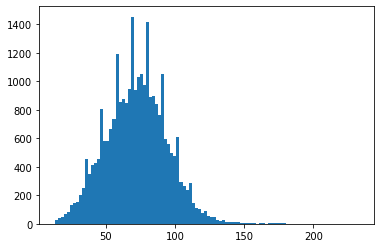

In [60]:
print(f"최대 길이 : {max(len(i) for i in X_train)}")
print(f"평균 길이 : {sum(map(len, X_train))/len(X_train)}")
plt.hist([len(i) for i in X_train],bins=100)
plt.show()

padding 해주기 위해 length의 분포를 보고 적당히 잘라줍니다.

In [61]:
def below_threshold_len(max_len, nested_list):
  cnt=0
  for s in nested_list:
    if(len(s)<=max_len):
      cnt=cnt+1
  print(f"전체 샘플 중 길이가 {max_len}이하인 샘플의 비율 : {(cnt/len(nested_list))*100}")

max_len=200
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 200이하인 샘플의 비율 : 99.98172113767639


padding 연산

In [62]:
X_train=pad_sequences(X_train, maxlen=max_len)
X_valid=pad_sequences(X_valid, maxlen=max_len)
X_test=pad_sequences(X_test, maxlen=max_len)

In [63]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(27354, 200) (27354, 5)
(5122, 200) (5122, 5)


In [64]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = vocab_size
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = max_len
# This is fixed.
EMBEDDING_DIM = 100

In [65]:
model_path = f"{PATH}/models/" + morphs_processors[2] + '.hdf5'

wandb.init(project="2022SCHackathon", entity="yerim")
wandb.config = {
  "learning_rate": 0.1,
  "epochs": 100,
  "loss_function": "categorical_crossentropy",
  "architecture": "LSTM",
  "batch_size": 512
}
config=wandb.config

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001,verbose=1)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=5),
             keras.callbacks.ModelCheckpoint(filepath=model_path,
                                             monitor='val_loss',
                                             save_best_only=True),
              WandbCallback()]



accuracy,▁▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,█▆▅▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.7275
best_epoch,28
best_val_loss,0.92894
epoch,33
loss,0.76963
val_accuracy,0.66993


[model 참고 URL](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17)

In [66]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train,epochs=config["epochs"], batch_size=config["batch_size"],validation_data=(X_valid, y_valid),callbacks=callbacks)

Epoch 1/100
54/54 [==============================] - 46s 802ms/step - loss: 1.5499 - accuracy: 0.3340 - val_loss: 1.4509 - val_accuracy: 0.3890
Epoch 2/100
54/54 [==============================] - 45s 830ms/step - loss: 1.3867 - accuracy: 0.4118 - val_loss: 1.3292 - val_accuracy: 0.4326
Epoch 3/100
54/54 [==============================] - 43s 803ms/step - loss: 1.2860 - accuracy: 0.4563 - val_loss: 1.2297 - val_accuracy: 0.4986
Epoch 4/100
54/54 [==============================] - 44s 804ms/step - loss: 1.1882 - accuracy: 0.5183 - val_loss: 1.1634 - val_accuracy: 0.5375
Epoch 5/100
54/54 [==============================] - 44s 820ms/step - loss: 1.1297 - accuracy: 0.5561 - val_loss: 1.1281 - val_accuracy: 0.5671
Epoch 6/100
54/54 [==============================] - 45s 827ms/step - loss: 1.0869 - accuracy: 0.5851 - val_loss: 1.0805 - val_accuracy: 0.6025
Epoch 7/100
54/54 [==============================] - 44s 807ms/step - loss: 1.0156 - accuracy: 0.6319 - val_loss: 1.0368 - val_accuracy:

## 모델 Load & Execution line

In [78]:
model = keras.models.load_model(f"{PATH}/models/" + morphs_processors[0] + '.hdf5')
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

161/161 [==============================] - 8s 49ms/step - loss: 0.9433 - accuracy: 0.6605
Test set
  Loss: 0.943
  Accuracy: 0.660


In [96]:
new_complaint="오늘은 행복해. 행복한 하루를 보내야지! 다들 좋은 하루를 보냈으면 좋겠다."
new_complaint=[remove_stopwords(new_complaint)]
seq=tokenizer.texts_to_sequences(new_complaint)
padded=pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH)
pred=model.predict(padded)
print(pred)
print(np.argmax(pred))

[[0.10313848 0.46222737 0.20402637 0.24567586 0.9919424 ]]
4
